In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        # Learnable scale parameter
        self.scale = nn.Parameter(torch.ones(1))
        
    def forward(self, x):
        return x * self.scale
    
    
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.custom_layer = CustomLayer()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.custom_layer(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [32]:
import os
model = CNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    # Save checkpoint after each epoch (optional)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item()
    }
    torch.save(checkpoint, f'./checkpoints_ConvolutionalNN/model_checkpoint{epoch}.pth')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


checkpoint_file = './checkpoints_ConvolutionalNN/model_checkpoint3.pth'

if os.path.exists(checkpoint_file):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_file)

    # Restore the model, optimizer, and epoch
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    running_loss = checkpoint['loss']

    # If using GPU, ensure the model and optimizer are on the correct device
    model.to(device)

    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

num_epochs = 2
for epoch in range(start_epoch, start_epoch + num_epochs):  # Adjust the range as needed
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


C:\Users\dalop\AppData\Local\Temp\ipykernel_23700\4220377820.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Checkpoint loaded. Resuming training from epoch 4
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.008755
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.000930
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.001296
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.002565
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000838
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.001240
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.011851
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.000522
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.003149
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.002783

Test set: Average loss: 0.0261, Accuracy: 9919/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001056
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000442
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.030838
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001253
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.005734
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002315
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000531
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.013671
T

Predicted Class: 7


C:\Users\dalop\AppData\Local\Temp\ipykernel_23700\1080983693.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints_ConvolutionalNN/mode

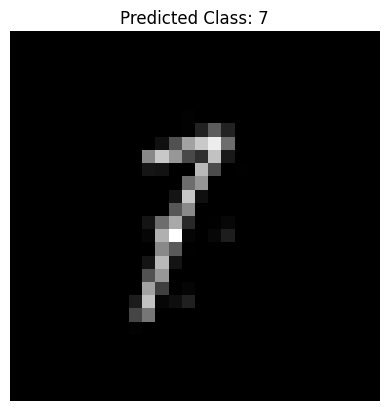

In [41]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Step 1: Load the image and preprocess it
image = Image.open('./individual_test_images/ochom.png')
image_gray = image.convert('L')
image_resized = image_gray.resize((28, 28))

# Convert the image to a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image_resized)

# Add a batch dimension (required by the model)
image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]

# Step 2: Load the model and put it in evaluation mode
model = CNNModel()
checkpoint = torch.load('./checkpoints_ConvolutionalNN/model_checkpoint3.pth')  # Load the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Step 3: Forward the image through the model
with torch.no_grad():  # No need to track gradients for inference
    output = model(image_tensor)

# Step 4: Interpret the output
predicted_class = output.argmax(dim=1, keepdim=True)  # Get the predicted class index
print(f'Predicted Class: {predicted_class.item()}')

# Step 5: Visualize the image (optional)
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class.item()}')
plt.axis('off')
plt.show()


In [36]:
64 * 7 * 7

3136